# Parser Script for Fornax CCSN Simulations

Get data from https://www.astro.princeton.edu/~burrows/nu-emissions.3d/

The guide to what's in the files is here: https://www.astro.princeton.edu/~burrows/nu-emissions.3d/README_SPH.pdf

What we want to do is estimate the average energy $\langle E\rangle$ and the "pinch parameter" $\alpha$ of the energy distribution as a function of time.

For now, we are computing $\langle E\rangle$ and $\alpha$ for a single timeslice.

In [68]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.special import gammaln
from scipy.optimize import minimize, basinhopping

from astropy.io import ascii, fits
import astropy.units as u
from astropy.table import Table

from snewpy.models import Fornax_2019
from snewpy.neutrino import Flavor

mpl.rc('font', size=10)

## Neutrino energy PDFs and Chi-Square Functions

Define a couple of variants of the neutrino energy PDF

$n(E_\nu) \propto E_\nu^\alpha \exp{\left[-\frac{(\alpha+1)E_\nu}{\langle E_\nu\rangle}\right]}$

and $\chi^2$ functions used to fit $\langle E_\nu\rangle$ and the pinch parameter $\alpha$ (if desired).

In [2]:
def log_enu_pdf(E, Ea, a):
    """Log of the energy spectrum of neutrinos with an average energy and pinch parameter.
    
    Parameters
    ----------
    Ea: float
        Average energy.
    a: float
        Pinch parameter (alpha).
        
    Returns:
    --------
    
    logpdf: float
        Natural log of the energy spectrum PDF.
    """
    return (1 + a) * np.log(1 + a) - gammaln(1 + a) + a * np.log(E) - \
           (1 + a) * np.log(Ea) - (1 + a) * (E / Ea)

def enu_pdf(E, A, Ea, a):
    """The energy spectrum of neutrinos with an average energy and pinch parameter.
    
    Parameters
    ----------
    Ea: float
        Average energy.
    a: float
        Pinch parameter (alpha).
        
    Returns:
    --------
    
    pdf: float
        The energy spectrum PDF.
    """
#     return np.exp(log_enu_pdf(E, Ea, a))
    return A * np.exp(a * np.log(E) - (1 + a) * (E / Ea))


def chi2(params, E, N):
    A, Eavg, alpha = params        
    return np.sum((N - enu_pdf(E, A, Eavg, alpha))**2)


def chi2_bounded(params, E, N):
    A, Eavg, alpha = params
    
    # Apply some physical boundaries by penalizing chi2 with
    # a large positive offset when the parameters are outside of
    # some physical range.
    offset = 0.
    if A <0. or A>10. or Eavg<0. or Eavg>20. or alpha<0. or alpha>10.:
        offset = 1e99
        
    return np.sum((N - enu_pdf(E, A, Eavg, alpha))**2) + offset

## Perform the Fit on the Fornax Model Class

In [3]:
ifile = '../../models/Fornax_2019/data/lum_spec_10M'
model = Fornax_2019(ifile)

In [19]:
# def compute_Eavg_alpha(flavor, t_idx):
#     dLdE = model.luminosity[flavor.name][:,t_idx].flatten().value
#     dLdE = dLdE/np.sum(dLdE)
#     Ec = model.energy[flavor.name][:,t_idx].flatten().value #* u.MeV
#     dE = np.full(np.shape(Ec), (Ec[0] - Ec[1])) #* u.MeV
#     Eavg = np.sum(dLdE * Ec * dE) / np.sum(dLdE * dE)
# #     Eavg_flav.append(Eavg)
#     E2avg = np.sum(dLdE * Ec**2 * dE) / np.sum(dLdE * dE)
#     r = E2avg / Eavg**2
#     alpha = (r - 2)/(1 - r)
# #     alpha_flav.append(alpha)
#     return Eavg, alpha

def fit_Eavg_alpha(flavor, t_idx, minimizer = 1):
    dLdE = model.luminosity[flavor.name][:,t_idx].flatten().value
    dLdE = dLdE/np.sum(dLdE)
    Ec = model.energy[flavor.name][:,t_idx].flatten().value #* u.MeV
    dE = np.full(np.shape(Ec), (Ec[0] - Ec[1])) #* u.MeV
    Eavg = np.sum(dLdE * Ec * dE) / np.sum(dLdE * dE)
#     Eavg_flav.append(Eavg)
    E2avg = np.sum(dLdE * Ec**2 * dE) / np.sum(dLdE * dE)
    r = E2avg / Eavg**2
    alpha = (r - 2)/(1 - r)
    
    p0 = [3., 10., 1.]
    bounds = [(0., 10.), (0.5*Eavg, 1.5*Eavg), (0.5*alpha, 1.5*alpha)]

    if minimizer == 1:
        # Use simulated annealing.
        res = basinhopping(chi2, p0, niter=100, T=0.1, stepsize=0.1,
                           minimizer_kwargs={'bounds':bounds,
                                             'tol':1e-6,
                                             'method':'L-BFGS-B',
                                             'args':(Ec[Ec<40], dLdE[Ec<40])})
    else:
        # Just use a BFGS minimizer.
        res = minimize(chi2, p0, args=(Ec, dLdE),
                       bounds=bounds,
                       options={'maxiter':10000},
                       tol=1e-6,
                       method='L-BFGS-B')
        
    return res.x

In [20]:
# t = model.time[10]
# flavor = Flavor.NU_E
# E = np.linspace(0,100,201) * u.MeV
# spectrum = model.get_initialspectra(t, E)

In [23]:
EAVG = {}
ALPHA = {}

for flavor in Flavor:
    Eavg_flav = []
    alpha_flav = []
    for i, t in enumerate(model.time): 
        A, Eavg, alpha = fit_Eavg_alpha(flavor, i)
        Eavg_flav.append(Eavg)
        alpha_flav.append(alpha)
#         break
    EAVG[flavor.name] = Eavg_flav
    ALPHA[flavor.name] = alpha_flav
#     print(flavor.name)
#     print(A, Eavg, alpha)

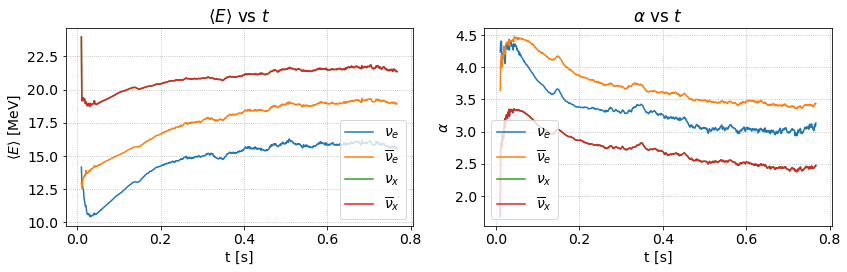

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))
ax1, ax2 = axes
for flavor in Flavor:
    ax1.plot(model.time, EAVG[flavor.name], label = flavor.to_tex())
    ax2.plot(model.time, ALPHA[flavor.name], label = flavor.to_tex())
ax1.set(title = '$\\langle E \\rangle$ vs $t$',
        xlabel = 't [s]',
        ylabel = '$\\langle E \\rangle$ [MeV]')
ax2.set(title = '$\\alpha$ vs $t$',
        xlabel = 't [s]',
        ylabel = '$\\alpha$')
ax1.legend()
ax2.legend()
ax1.grid(ls = ':')
ax2.grid(ls = ':')
fig.tight_layout()

In [26]:
fig.savefig('Eavg_alpha_vs_time.png')

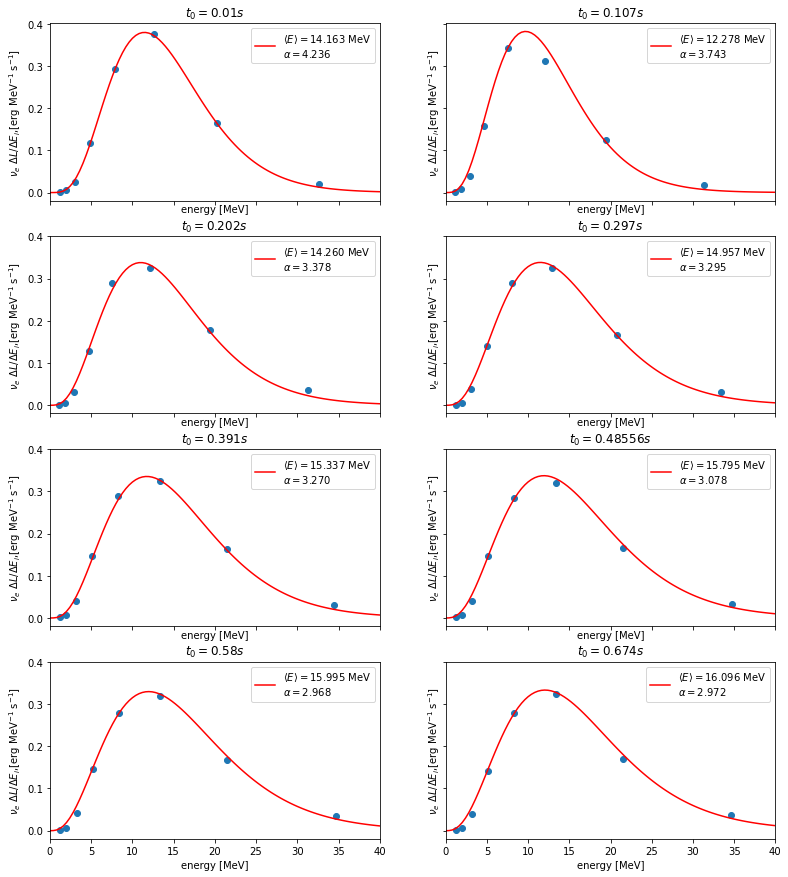

In [66]:
## Sanity check
t_idx = [0, 100, 200, 300, 400, 500, 600, 700]
flavor = Flavor.NU_E
energies = np.linspace(1e-6, 40, 101)
A = [5.4, 4.9, 5.2, 5.5, 5.6, 5.9, 5.9, 6.0]
fig, axes = plt.subplots(4, 2, figsize = (13, 15), sharex = True, sharey=True)
for i, a, ax in zip(t_idx, A, axes.flatten()):
#     fig, ax = plt.subplots(1, 1, figsize = (7, 4))
    t = model.time[i]
    dLdE = model.luminosity[flavor.name][:,i].flatten().value
    dLdE = dLdE/np.sum(dLdE)
    Ec = model.energy[flavor.name][:,i].flatten().value
    
    Eavg_fit = EAVG[flavor.name][i]
    alpha_fit = ALPHA[flavor.name][i]
    bestfit = a*np.exp(log_enu_pdf(energies, Eavg_fit, alpha_fit))
    
    ax.plot(Ec, dLdE, 'o')
    ax.plot(energies, bestfit, 'r-', label='$\\langle E\\rangle = {:.3f}$ MeV \n$\\alpha = {:.3f}$'.format(Eavg_fit, alpha_fit))
    ax.legend()
    ax.set(title='$t_0={:g}$'.format(t),
           xlim=(0,40),
           xlabel='energy [MeV]',
           ylabel=r'$\nu_e$ $\Delta L/\Delta E_i$,[erg MeV$^{-1}$ s$^{-1}$]')
#     break

In [67]:
fig.savefig('Eavg_alpha_fit_timeslices_{}.png'.format(flavor.name))

In [27]:
# EAVG['NU_E'][0]

14.16252103489719

In [73]:
TIME = model.time

EAVG_NU_E = EAVG['NU_E'] * u.MeV
EAVG_NU_E_BAR = EAVG['NU_E_BAR'] * u.MeV
EAVG_NU_X = EAVG['NU_X'] * u.MeV
EAVG_NU_X_BAR = EAVG['NU_X_BAR'] * u.MeV

ALPHA_NU_E = ALPHA['NU_E']
ALPHA_NU_E_BAR = ALPHA['NU_E_BAR']
ALPHA_NU_X = ALPHA['NU_X']
ALPHA_NU_X_BAR = ALPHA['NU_X_BAR']

tab = Table([TIME, EAVG_NU_E, EAVG_NU_E_BAR, EAVG_NU_X, EAVG_NU_X_BAR, 
             ALPHA_NU_E, ALPHA_NU_E_BAR, ALPHA_NU_X, ALPHA_NU_X_BAR],
            names = ('TIME', 'EAVG_NU_E', 'EAVG_NU_E_BAR', 'EAVG_NU_X', 'EAVG_NU_X_BAR', 
                     'ALPHA_NU_E', 'ALPHA_NU_E_BAR', 'ALPHA_NU_X', 'ALPHA_NU_X_BAR'))

In [75]:
tab.write('Fornax_Eavg_alpha_.fits', format = 'fits', overwrite = True)

In [76]:
tab

TIME,EAVG_NU_E,EAVG_NU_E_BAR,EAVG_NU_X,EAVG_NU_X_BAR,ALPHA_NU_E,ALPHA_NU_E_BAR,ALPHA_NU_X,ALPHA_NU_X_BAR
s,MeV,MeV,MeV,MeV,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.01,14.16252103489719,12.977557338330907,23.966972642124222,23.966972642124222,4.235574796896764,3.635945233082081,1.6750992604266384,1.6750992604266384
0.011000000000000286,13.145359979680824,12.581853379113815,19.166232637900563,19.166190830242236,4.3725184505915955,4.106547125844232,2.7133524333802423,2.7133524333802423
0.012000000000000339,12.901941106656091,12.815795354970112,19.2175729070473,19.21765751793769,4.403842334931101,4.119623675969569,2.765076240395971,2.765076240395971
0.01300000000000049,12.696520806386074,13.032305757683734,19.186840783722765,19.186827331826354,4.398606470138648,4.203930204932677,2.8315469195891936,2.8315469195891936
0.014000000000000092,12.492763720239052,13.281295983702272,19.39428313503001,19.394265414005996,4.122507473238876,3.9991755836753904,2.7543326037240545,2.7543326037240545
0.015000000000000187,12.449138337347968,13.385557849574958,19.223749360252118,19.223735352389614,4.121375469325647,4.174799183011655,2.95962798291628,2.95962798291628
0.016000000000000923,11.917122656306736,13.383889206454361,19.271042437865674,19.270955011981656,4.194290072692011,4.1419221524679655,2.8628706005871454,2.8628706005871454
0.01700000000000066,11.694925342116234,13.501797429964023,19.304580051130845,19.304572990274444,4.213006830024061,4.1273003389631935,2.8735712595351854,2.8735712595351854
